# Visual Material Recognition

### EDA

This notebook contains explanatory data analysis for visual material recognition paper. <br>
The goal is to predict hardness of the material based on the image of its microstructure. <br>

### Paths

In [1]:
import sys

root_path = ".."  # top-level of the repository

sys.path.append(root_path)

### Setup

In [2]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from src.metrics import regression_report

In [3]:
sns.set()
plt.rcParams["figure.figsize"] = (16, 10)

# Data

In [4]:
mesurements_df = pd.read_csv("../data/measurements.csv")
mesurements_df.head(3)

,Sample,Hardness,File,Location,DELETED
0,1-101-1,115.0,data/images/raw/1-101.jpg,top-left,True
1,1-101-2,129.9,data/images/raw/1-101.jpg,top-right,False
2,1-101-3,130.0,data/images/raw/1-101.jpg,bottom-right,True


In [5]:
len(mesurements_df) // 4

288

Discard deleted images

In [6]:
pd.concat(
    [
        mesurements_df["DELETED"].value_counts(),
        mesurements_df["DELETED"].value_counts(normalize=True),
    ],
    axis=1
)

,DELETED,DELETED
False,942,0.817708
True,210,0.182292


### Label Outliers

In [7]:
# drop the image location code from sample labels
mesurements_df["Code"] = mesurements_df["Sample"].apply(lambda sample: "-".join(sample.split("-")[:-1]))

In [8]:
# the number of unique material samples measured
mesurements_df["Code"].nunique()

288

In [9]:
def max_from_mean(array):
    return np.abs(array - array.mean()).max()

In [10]:
pd.concat([
    mesurements_df.groupby(by="Code")["Hardness"].std().describe().rename("Sample Std"),
    mesurements_df.groupby(by="Code")["Hardness"].apply(max_from_mean).describe().rename("Max Deviation"),
], axis=1)

,Sample Std,Max Deviation
count,287.000000,287.000000
mean,5.579861,7.158595
std,3.541815,4.753151
min,0.485627,0.625000
25%,3.040696,3.700000
50%,4.454492,5.775000
75%,7.095561,9.200000
max,18.461920,24.525000


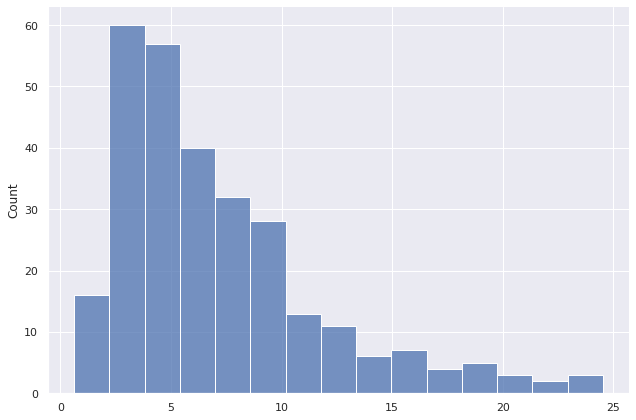

In [11]:
_ = sns.displot(mesurements_df.groupby(by="Code")["Hardness"].apply(max_from_mean).rename("Max Deviation").values, kind="hist", aspect=1.5, height=6)

In [12]:
cutoff = 10  # cut-off at max deviation from mean in HV

max_from_mean_values = mesurements_df.groupby(by="Code")["Hardness"].apply(max_from_mean)
to_delete = max_from_mean_values.loc[max_from_mean_values > cutoff].index.tolist()
to_delete = mesurements_df["Code"].loc[mesurements_df["Code"].isin(to_delete)].index.tolist()

In [13]:
mesurements_df = mesurements_df.drop(to_delete)
mesurements_df = mesurements_df.drop(mesurements_df.loc[mesurements_df["DELETED"] == True].index)  # drop values marked as DELETED or TO DELETE
mesurements_df = mesurements_df.drop(columns="DELETED")  # drop column

mesurements_df.head()

,Sample,Hardness,File,Location,Code
5,1-102-2,137.6,data/images/raw/1-102.jpg,top-right,1-102
7,1-102-4,127.8,data/images/raw/1-102.jpg,bottom-left,1-102
9,1-103-2,140.0,data/images/raw/1-103.jpg,top-right,1-103
11,1-103-4,139.5,data/images/raw/1-103.jpg,bottom-left,1-103
13,1-104-2,152.3,data/images/raw/1-104.jpg,top-right,1-104


Measurments file contains 4 columns:
* Sample label
* Measured hardness
* Path to image file of given sample
* Measurement location

In [14]:
mesurements_df["Hardness"].describe().apply(lambda value: f"{value:.2f}").to_frame()

,Hardness
count,768.00
mean,137.93
std,7.04
min,114.10
25%,133.47
50%,138.85
75%,142.60
max,162.00


In [15]:
series_1_2_values = mesurements_df.loc[(mesurements_df["Sample"].str.startswith("1")) | (mesurements_df["Sample"].str.startswith("2"))]
series_3_values = mesurements_df.loc[(mesurements_df["Sample"].str.startswith("3"))]

pd.concat([series_1_2_values, series_3_values], axis=1).describe()

,Hardness,Hardness
count,279.000000,489.000000
mean,133.794982,140.287935
std,8.366857,4.769799
min,114.100000,125.400000
25%,127.950000,137.100000
50%,132.400000,140.100000
75%,138.750000,143.500000
max,162.000000,157.400000


Two plots included in the original (pre-review) version of the paper

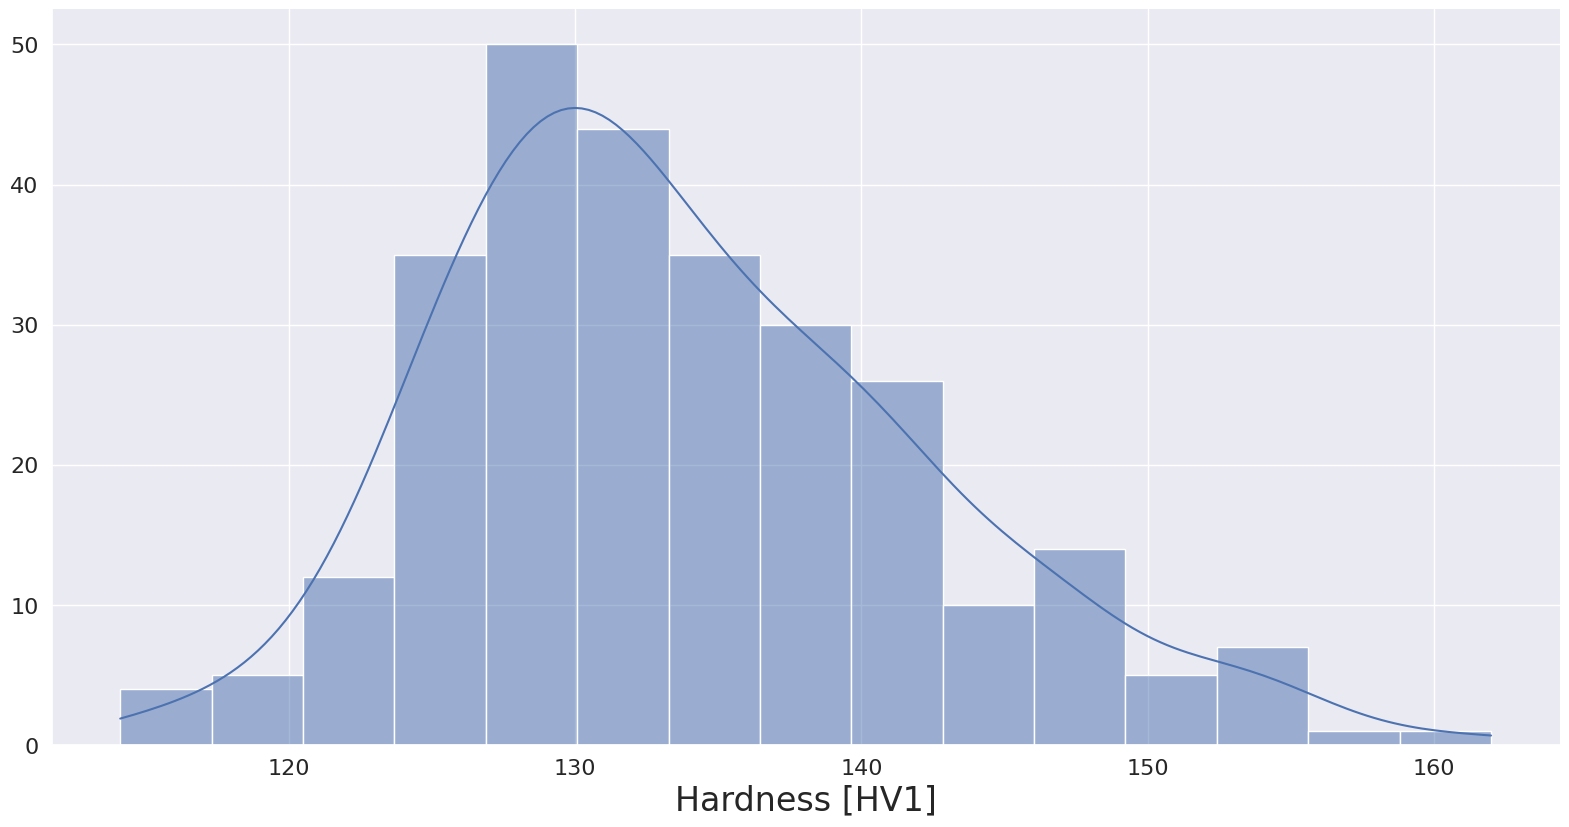

In [16]:
series_1_2_values = mesurements_df.loc[(mesurements_df["Sample"].str.startswith("1")) | (mesurements_df["Sample"].str.startswith("2"))]
_ = sns.displot(series_1_2_values["Hardness"].values, kde=True, aspect=2, height=8)
_ = plt.xlabel("Hardness [HV1]", fontsize=24)
_ = plt.ylabel("")
_ = plt.xticks(fontsize=16)
_ = plt.yticks(fontsize=16)

# uncomment to overwrite figure
# _ = plt.savefig("../data/plots/series-1-2-hardness-distribution.png", bbox_inches="tight")

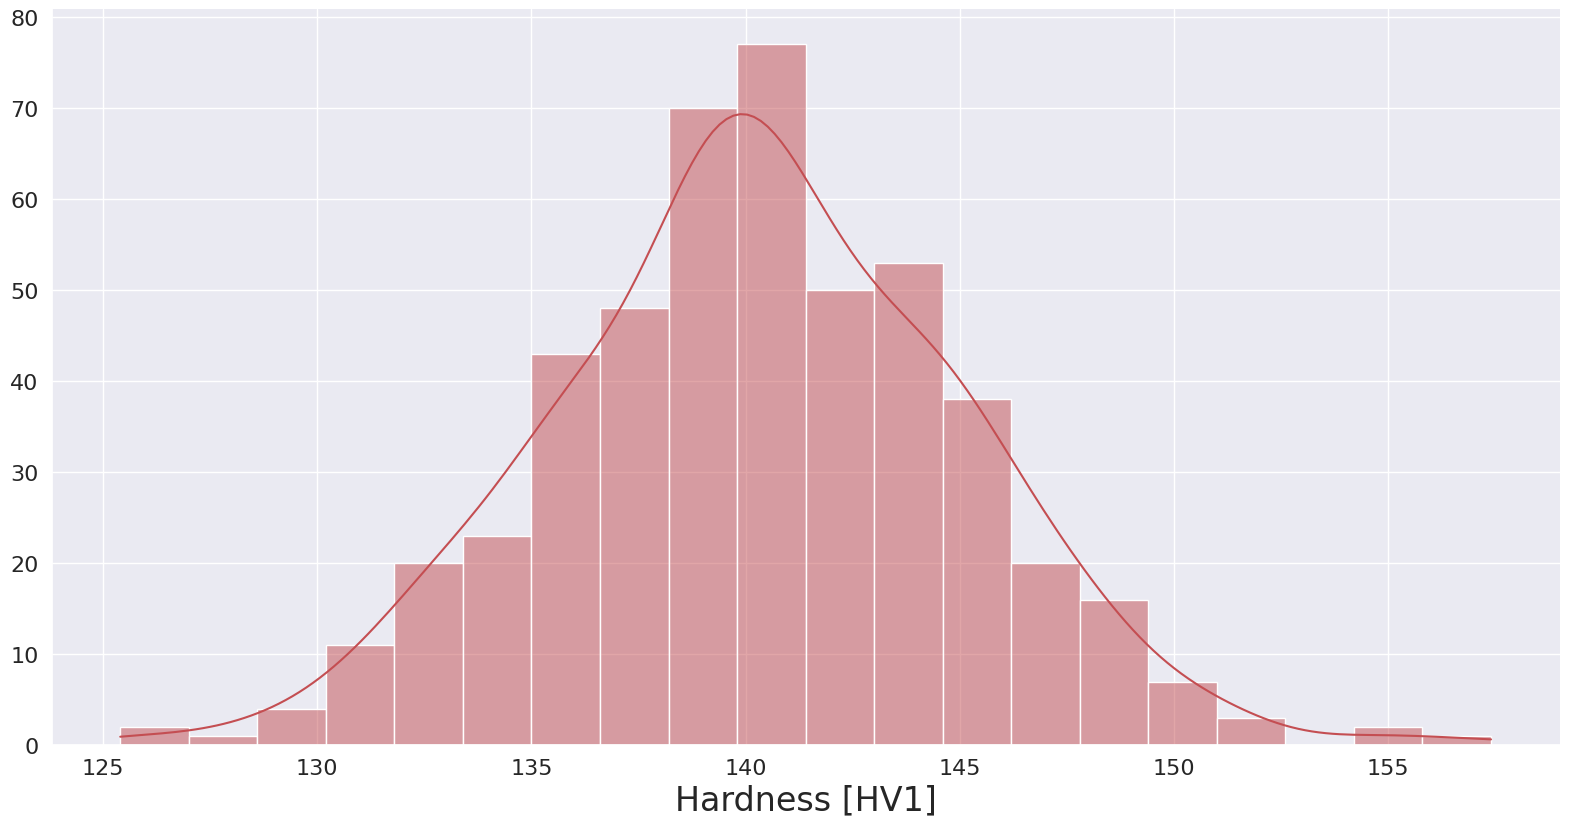

In [17]:
series_3_values = mesurements_df.loc[(mesurements_df["Sample"].str.startswith("3"))]
_ = sns.displot(series_3_values["Hardness"].values, color="r", kde=True, aspect=2, height=8)
_ = plt.xlabel("Hardness [HV1]", fontsize=24)
_ = plt.ylabel("")
_ = plt.xticks(fontsize=16)
_ = plt.yticks(fontsize=16)

# uncomment to overwrite figure
# _ = plt.savefig("../data/plots/series-3-hardness-distribution.png", bbox_inches="tight")

Plot included in the published version, following suggestions from the review.

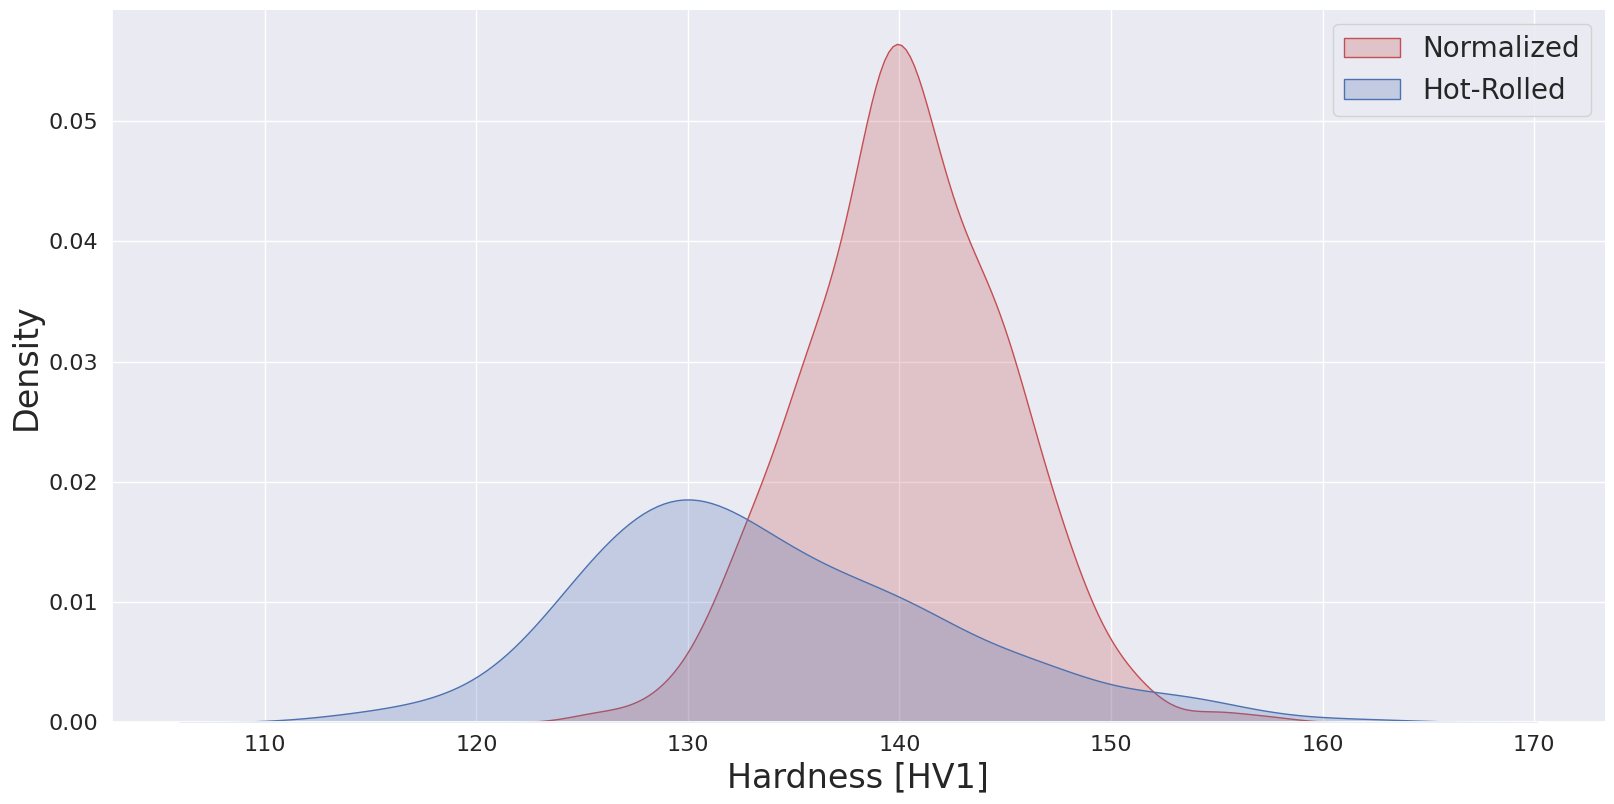

In [18]:
def get_steel_type_name(sample):
    if sample.startswith("1") or sample.startswith("2"):
        return "Normalized"
    elif sample.startswith("3"):
        return "Hot-Rolled"
    raise ValueError("Incorrect sample code!")

mesurements_df["Steel Name"] = mesurements_df["Sample"].apply(get_steel_type_name)

_ = sns.displot(data=mesurements_df, x="Hardness", hue="Steel Name", kind="kde", fill=True, palette=["b", "r"], aspect=2, height=8, legend=False)
_ = plt.xlabel("Hardness [HV1]", fontsize=24)
_ = plt.ylabel("Density", fontsize=24)
_ = plt.legend(["Normalized", "Hot-Rolled"], fontsize=20)
_ = plt.xticks(fontsize=16)
_ = plt.yticks(fontsize=16)

# uncomment to overwrite figure
# _ = plt.savefig("../data/plots/hardness-distribution.png", bbox_inches="tight")

In [20]:
mesurements_df.groupby(by="Steel Name").describe().applymap(lambda value: round(value, 2)).transpose()

Steel Name      Hot-Rolled  Normalized
Hardness count      489.00      279.00
         mean       140.29      133.79
         std          4.77        8.37
         min        125.40      114.10
         25%        137.10      127.95
         50%        140.10      132.40
         75%        143.50      138.75
         max        157.40      162.00

# Example

In [21]:
def load_and_display(path):
    """Util function for EDA purpose"""
    image = io.imread(path)
    io.imshow(image)
    
def sample_one(column):
    """Samples one element from pandas Series"""
    return column.sample(1).tolist()[0]

In [22]:
# map path to relative
mesurements_df["File"] = mesurements_df["File"].apply(lambda path: os.path.join("..", path))

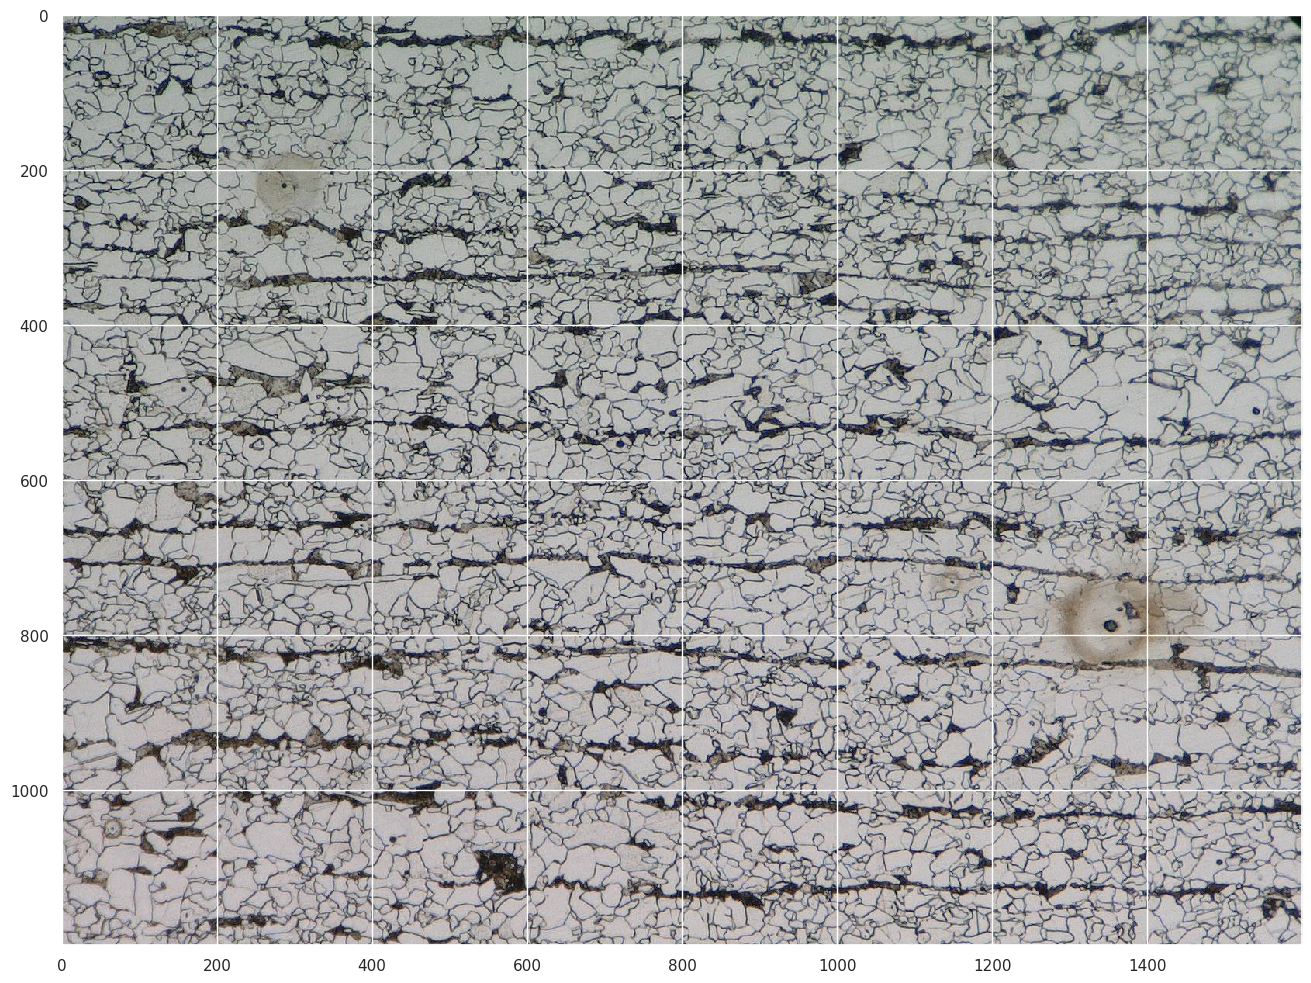

In [23]:
# grid is caused by using seaborn default style
load_and_display(sample_one(mesurements_df["File"]))

# Prepare Files

Split images from dataset into files. Right now each image contains up to 4 measurements.

In [24]:
def load_and_split(path, loc):
    """Loads part of the image given by location"""
    image = io.imread(path)
    heigth = image.shape[0] // 2
    width = image.shape[1] // 2
    
    if loc == "top-left":
        return image[:heigth, :width, :]
    if loc == "top-right":
        return image[:heigth, width:, :]
    if loc == "bottom-right":
        return image[heigth:, width:, :]
    if loc == "bottom-left":
        return image[heigth:, :width, :]


def save_sample(image, sample):
    path = f"../data/images/processed/{sample}.jpg"
    io.imsave(path, image)
    return path
    
def prepare_image(row):
    try:
        image = load_and_split(row["File"], row["Location"])
        target_path = save_sample(image, row["Sample"])
        return target_path

    except FileNotFoundError:
        print(f'Missing raw image for sample: {row["Sample"]} with path {row["File"]}')

In [25]:
mesurements_df["File"] = mesurements_df.apply(prepare_image, axis="columns")

In [27]:
# uncomment to overwrite
mesurements_df.to_csv("../data/dataset.csv", index=False)